In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from scipy import stats
import numpy as np
import network_dataloader as ndl
import pickle

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


## Get pretrained model

In [2]:
net = models.vgg16(pretrained=True, progress=True).to(device=device)

In [3]:
net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Modify the last layer to output the same as input

In [4]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
    
net.classifier[6] = Identity()

## Get dataset

In [5]:
batchSize = 46
input_size = 224
# Load Data
data_transforms = {
        'train': transforms.Compose([
                ndl.Rescale(input_size),
                ndl.ToTensor()]), 
        'test': transforms.Compose([
                ndl.Rescale(input_size),
                ndl.ToTensor()])
        }

print("Initializing Datasets and Dataloaders...")

# Create training and testing datasets
image_datasets = {x: ndl.TopoplotLoader('images', x, data_transforms[x]) for x in ['train', 'test']}

# Create training and testing dataloaders
dataloaders_dict = {'train': Data.DataLoader(image_datasets['train'], batch_size=batchSize, shuffle=True, num_workers=4),
                    'test':  Data.DataLoader(image_datasets['test'], batch_size=batchSize, shuffle=False, num_workers=4)}

Initializing Datasets and Dataloaders...
> Found 636 images...
> Found 46 images...


## Extract features by VGG16 

In [6]:
net.eval() # Disable batchnorm, dropout

# Training data
for i_samples, samples in enumerate(dataloaders_dict['train']):
    imgs = samples['image'].to(device=device)
    labels = samples['label'].to(device=device)
    
    if i_samples == 0:
        with torch.no_grad():
            X_train = net(imgs).cpu().numpy()
        Y_train = labels.cpu().numpy()
    else:
        with torch.no_grad():
            X_train = np.concatenate((X_train, net(imgs).cpu().numpy()), axis=0)
        Y_train = np.concatenate((Y_train, labels.cpu().numpy()), axis=0)
    
print('X_train shape : ', X_train.shape)
print('Y_train shape : ', Y_train.shape)
    
# Testing data
for samples in dataloaders_dict['test']:
    imgs = samples['image'].to(device=device)
    labels = samples['label'].to(device=device)
    
    with torch.no_grad():
        X_test = net(imgs).cpu().numpy()
    Y_test = labels.cpu().numpy()
    
print('X_test shape : ', X_test.shape)
print('Y_test shape : ', Y_test.shape)
    


X_train shape :  (636, 4096)
Y_train shape :  (636,)
X_test shape :  (46, 4096)
Y_test shape :  (46,)


## Apply PCA to reduct dimension

In [7]:
pca = PCA(n_components=0.9, svd_solver='full')
pca.fit(X_train)

X_train_PCA = pca.transform(X_train)
X_test_PCA = pca.transform(X_test)

print('X_train_PCA shape : ', X_train_PCA.shape)
print('X_test_PCA shape : ', X_test_PCA.shape)

X_train_PCA shape :  (636, 11)
X_test_PCA shape :  (46, 11)


In [8]:
pca.explained_variance_

array([72.18672  , 14.319957 ,  5.1277895,  4.476086 ,  2.5328393,
        2.252937 ,  1.8502954,  1.6875454,  1.3919526,  1.0843022,
        0.9335875], dtype=float32)

## Regression to predict solution time

In [9]:
def plot_scatter(true, pred, fileName):
    # Sort SLs in increasing order
    sorted_indices = np.argsort(true)
    sorted_true = true[sorted_indices]
    sorted_pred = pred[sorted_indices]

    max_value = np.max(np.hstack((true, pred)))
    plt.scatter(sorted_true, sorted_pred, marker='.')
    axes = plt.gca()
    axes.set_xlim([0, max_value])
    axes.set_ylim([0, max_value])
    plt.xlabel('True')
    plt.ylabel('Pred')
    
    plt.savefig('./results/%s.png'%(fileName))

In [20]:
X_train_Reg = X_train_PCA
X_test_Reg = X_test_PCA
#rgr = linear_model.LinearRegression()
rgr = linear_model.Ridge(alpha=1)
#rgr = svm.SVR()
rgr.fit(X_train_Reg, Y_train)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

Standard error: (14.929140,16.428232)
R squared: (0.185443,0.074535)


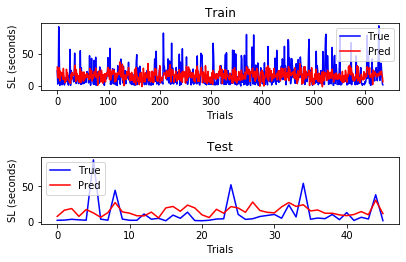

In [21]:
fig, axs = plt.subplots(2,1)

num_train = len(Y_train)
pred_train = rgr.predict(X_train_Reg).flatten()
axs[0].plot(range(num_train), Y_train, 'b', range(num_train), pred_train, 'r')
axs[0].set_xlabel('Trials')
axs[0].set_ylabel('SL (seconds)')
axs[0].legend(('True', 'Pred'))
axs[0].set_title('Train')

num_test = len(Y_test)
pred_test = rgr.predict(X_test_Reg).flatten()
axs[1].plot(range(num_test), Y_test, 'b', range(num_test), pred_test, 'r')
axs[1].set_xlabel('Trials')
axs[1].set_ylabel('SL (seconds)')
axs[1].legend(('True', 'Pred'))
axs[1].set_title('Test')

fig.tight_layout(pad=2.0)

print('Standard error: (%f,%f)'%(mean_squared_error(Y_train, pred_train)**0.5, mean_squared_error(Y_test, pred_test)**0.5) )
print('R squared: (%f,%f)'%(r2_score(Y_train, pred_train), r2_score(Y_test, pred_test)))


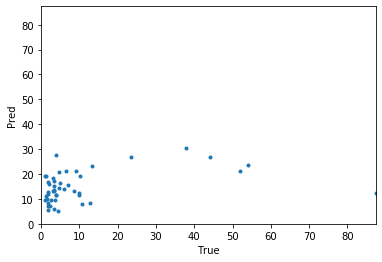

In [22]:
plot_scatter(Y_test, pred_test, 'VGG16_PCA_Ridge_SMOTER')

# Read result

Standard error: (12.380698, 16.156709)
R squared: (0.387423, 0.122973)


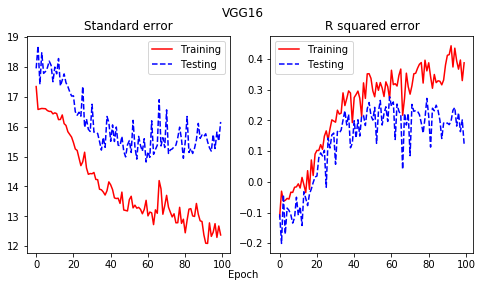

In [5]:
model_name = 'VGG16_SMOTER_Sigmoid'
# Load training error data
with open('%s.data'%(model_name), 'rb') as fp:
    dict_error = pickle.load(fp)
    
epoch = list(range(len(dict_error['train_std'])))
fig, axs = plt.subplots(1, 2, figsize=(8,4))
fig.suptitle('VGG16')

axs[0].plot(epoch, dict_error['train_std'], 'r-', epoch, dict_error['test_std'], 'b--')
axs[0].set_title('Standard error')
axs[0].legend(('Training', 'Testing'))
axs[1].plot(epoch, dict_error['train_r2'], 'r-', epoch, dict_error['test_r2'], 'b--')
axs[1].set_title('R squared error')
axs[1].legend(('Training', 'Testing'))

fig.text(0.5, 0.04, 'Epoch', ha='center')
fig.savefig('./results/%s.png'%(model_name))

print('Standard error: (%f, %f)'%(dict_error['train_std'][-1], dict_error['test_std'][-1]))
print('R squared: (%f, %f)'%(dict_error['train_r2'][-1], dict_error['test_r2'][-1]))

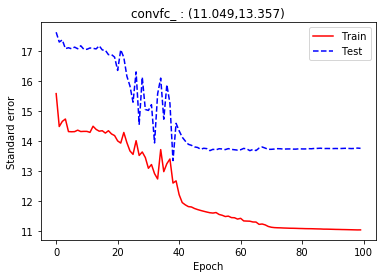

In [10]:
model_name = 'convfc_'

# Load error data
with open('./results/%s.data'%(model_name), 'rb') as fp:
    dict_error = pickle.load(fp)
    
epoch = list(range(len(dict_error['train'])))
plt.plot(epoch, dict_error['train'], 'r-', epoch, dict_error['test'], 'b--')
plt.xlabel('Epoch')
plt.ylabel('Standard error')
plt.title('%s : (%.3f,%.3f)'%(model_name, min(dict_error['train']), min(dict_error['test'])))
plt.legend(('Train', 'Test'))

plt.savefig('./results/%s.png'%(model_name))